# **OpenVisus Tutorial: Terrain Parameters**



## Step 1 - Data Generation

The first step talks about the data source for this particular example, we are using the [SOMOSPIE](https://github.com/TauferLab/SOMOSPIE) workflow with which we will generate the terrain parameters for the state of Tennessee, the files generated by this workflow are images in Tiff format.


### Import Dependencies
Run this cell to import all the dependencies you need to run the entire notebook

In [1]:
import geotiled as gt
from pathlib import Path
import glob
import os
import shutil
import shutil
import time
import multiprocessing
import OpenVisus as ov
import numpy as np
import requests
import json
from matplotlib import pyplot as plt

#To silence a deprecation warning. 
gt.gdal.UseExceptions()

### Generating data scratch

Run these cells in case you want to generate the terrain parameters from scratch

> **Note:** All the necessary files are already inside the container. 

In [3]:
download_list = "./download_urls.txt" #Where the list of download links will be stored
root_output_folder = './files/tif_files/' #root folder where geotiled will store data
n_tiles = 16 #Number of tiles that are generated for parameter computation
dem_tiles_dir_name = "tiles" #Folder where downloaded DEM tiles will be saved
param_tiles_dir_name = "elevation_tiles" #Folder where computation tiles will be saved. 
gcs_name = "gcs.tif" #Name for the mosaicked DEM
pcs_name = "pcs.tif" #Name for the projected DEM
shapefile = ["./files/shape_files/STATEFP_47.shp"] #Shapefile for Visualization
region_bounding_box = {"xmin": -90.4,"ymin": 34.8,"xmax": -81.55,"ymax": 36.8} #For `fetch_dem`. X=Longitude Y=Latitude. Determine bounding coordinates by looking at a map.

In [4]:
#Fetching Data
tiles_folder = os.path.join(root_output_folder, dem_tiles_dir_name)
Path(root_output_folder).mkdir(parents=True, exist_ok=True)
Path(tiles_folder).mkdir(parents=True, exist_ok=True)

#Setting up for parameter computation
gcs = os.path.join(root_output_folder,gcs_name)
pcs = os.path.join(root_output_folder,pcs_name)
elevation_tiles = os.path.join(root_output_folder, param_tiles_dir_name)
Path(elevation_tiles).mkdir(parents=True, exist_ok=True)

#Computing Parameters
aspect_tiles = os.path.join(root_output_folder, 'aspect_tiles')
hillshading_tiles = os.path.join(root_output_folder, 'hillshading_tiles')
slope_tiles = os.path.join(root_output_folder, 'slope_tiles')
Path(aspect_tiles).mkdir(parents=True, exist_ok=True)
Path(hillshading_tiles).mkdir(parents=True, exist_ok=True)
Path(slope_tiles).mkdir(parents=True, exist_ok=True)

In [5]:
gt.fetch_dem(bbox=region_bounding_box,txtPath=download_list, dataset="National Elevation Dataset (NED) 1 arc-second Current")
gt.download_files(download_list, tiles_folder)

./download_urls.txt


Downloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [02:36<00:00, 11.0MB/s]


In [6]:
raster_list = glob.glob(tiles_folder + '/*')

gt.build_mosaic(raster_list, gcs)

shutil.rmtree(tiles_folder)
os.remove("./merged.vrt")

0...10...20...30...40...50...60...70...80...90...

In [7]:
gt.reproject(gcs, pcs, "EPSG:9822")

os.remove(gcs)

100 - done.
0...10...20...30...40..

In [8]:
gt.crop_into_tiles(pcs, elevation_tiles, n_tiles)

glob_of_tiles = glob.glob(elevation_tiles + '/*.tif')

.50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90..

In [9]:
pool = multiprocessing.Pool(processes=n_tiles) 
pool.map(gt.compute_geotiled, sorted(glob.glob(elevation_tiles + '/*.tif')))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [10]:
gt.build_mosaic_filtered(sorted(glob.glob(aspect_tiles + '/*.tif')), os.path.join(root_output_folder, 'aspect.tif'))
gt.build_mosaic_filtered(sorted(glob.glob(hillshading_tiles + '/*.tif')), os.path.join(root_output_folder,'hillshading.tif'))
gt.build_mosaic_filtered(sorted(glob.glob(slope_tiles + '/*.tif')), os.path.join(root_output_folder, 'slope.tif'))


shutil.rmtree(aspect_tiles)
shutil.rmtree(hillshading_tiles)
shutil.rmtree(slope_tiles)
shutil.rmtree(elevation_tiles)

Reprojecting..
.100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...Cropping with combined shapefiles...
60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)


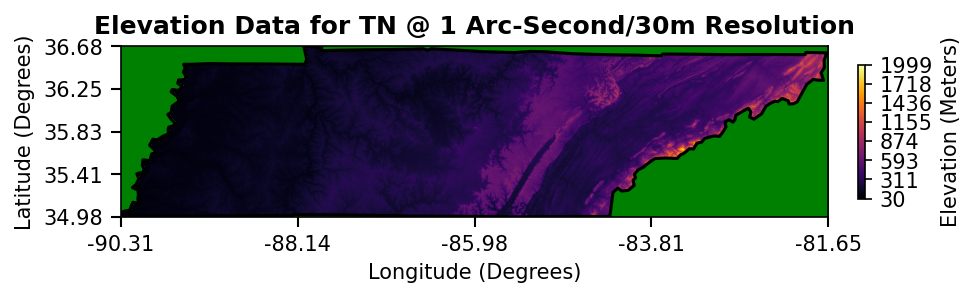

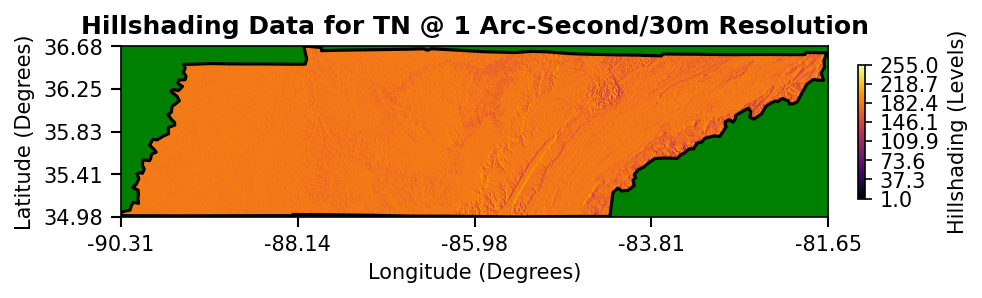

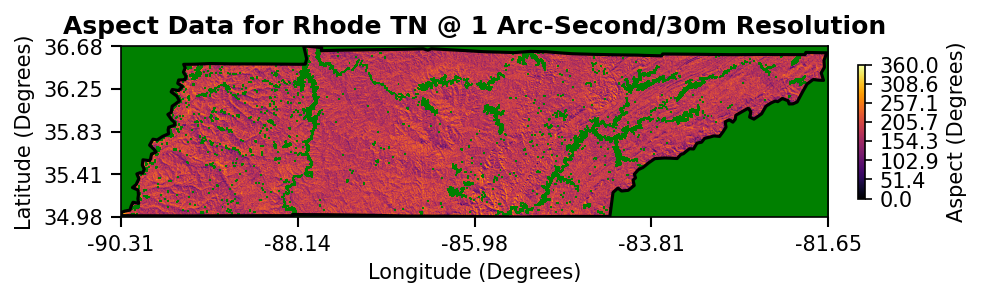

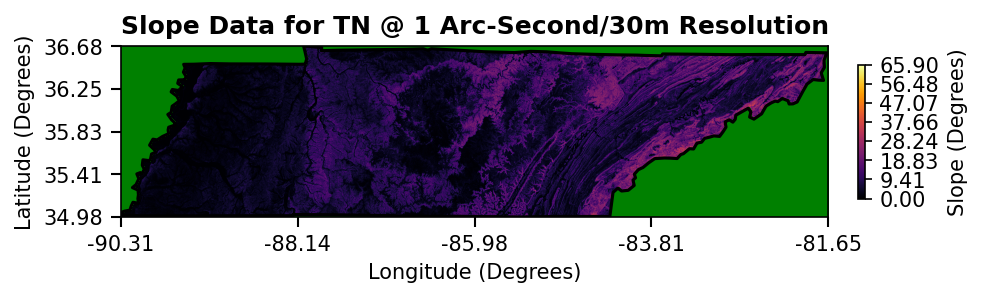

In [11]:
hill = os.path.join(root_output_folder, 'hillshading.tif')
aspect = os.path.join(root_output_folder, 'aspect.tif')
slope = os.path.join(root_output_folder, 'slope.tif')


pcs_array=gt.generate_img(pcs,    downsample=5, reproject_gcs=True, shp_files=shapefile, title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",    zunit="Meter",   xyunit="Degree", ztype="Elevation",   crop_shp=True) 
hill_array=gt.generate_img(hill,   downsample=5, reproject_gcs=True, shp_files=shapefile, title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",  zunit="Level",   xyunit="Degree", ztype="Hillshading", crop_shp=True)
aspect_array=gt.generate_img(aspect, downsample=5, reproject_gcs=True, shp_files=shapefile, title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution", zunit="Degree",  xyunit="Degree", ztype="Aspect",      crop_shp=True)
slope_array=gt.generate_img(slope,  downsample=5, reproject_gcs=True, shp_files=shapefile, title="Slope Data for TN @ 1 Arc-Second/30m Resolution",        zunit="Degree",  xyunit="Degree", ztype="Slope",       crop_shp=True)

### Getting data from dataverse

Run these cells in case you want to download the previously generated tiff files from dataverse

In [19]:
with open("./files/json/dataverse.json","r") as file:
    urls = json.load(file)

def get_data_from_dataverse(file_url, name_file):
    resp = requests.get(file_url)
    with open(name_file, 'wb') as f:
        f.write(resp.content)


for data in urls:
    get_data_from_dataverse(data.get('url'), data.get('name_file'))

Reprojecting..
0...10...20...30...40...50...60...70...80..Cropping with combined shapefiles...
.90...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...60...70...80...90Cropping with combined shapefiles...
...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...60...70...80..Cropping with combined shapefiles...
.90...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...60...70...80..Cropping with combined shapefiles...
.90...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading

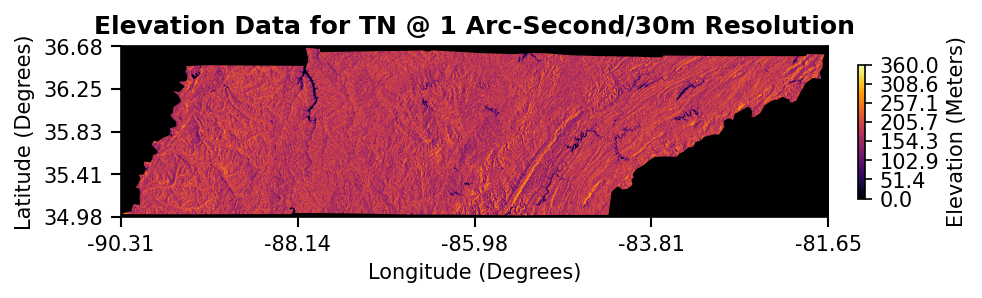

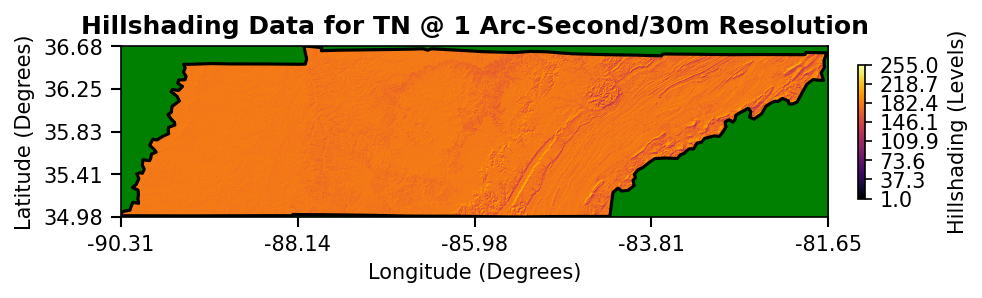

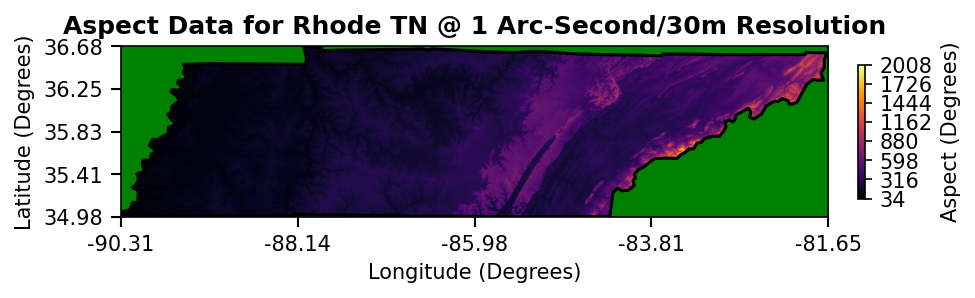

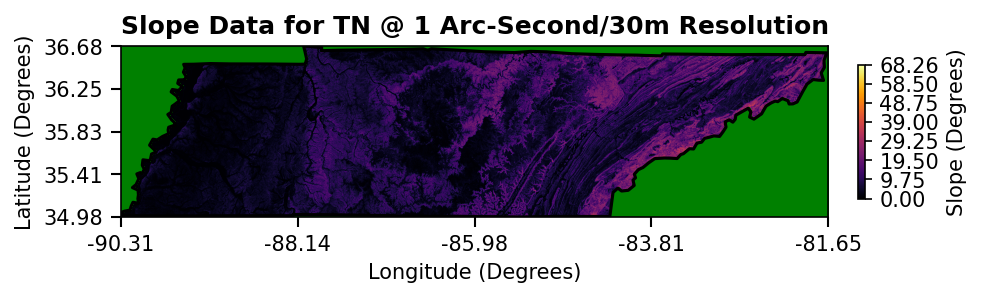

In [2]:
shapefile = ["./files/shape_files/STATEFP_47.shp"] #Shapefile for Visualization
hill = os.path.join('./files/tif_files/','TN_30M_hillshading.tif')
pcs = os.path.join('./files/tif_files/','TN_30M_aspect.tif')
aspect = os.path.join('./files/tif_files/','TN_30M_elevation.tif')
slope = os.path.join('./files/tif_files/','TN_30M_slope.tif')
pcs_array=gt.generate_img(pcs,    downsample=5, reproject_gcs=True, shp_files=shapefile, title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",    zunit="Meter",   xyunit="Degree", ztype="Elevation",   crop_shp=True) 
hill_array=gt.generate_img(hill,   downsample=5, reproject_gcs=True, shp_files=shapefile, title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",  zunit="Level",   xyunit="Degree", ztype="Hillshading", crop_shp=True)
aspect_array=gt.generate_img(aspect, downsample=5, reproject_gcs=True, shp_files=shapefile, title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution", zunit="Degree",  xyunit="Degree", ztype="Aspect",      crop_shp=True)
slope_array=gt.generate_img(slope,  downsample=5, reproject_gcs=True, shp_files=shapefile, title="Slope Data for TN @ 1 Arc-Second/30m Resolution",        zunit="Degree",  xyunit="Degree", ztype="Slope",       crop_shp=True)

## Step 2 - Conversion to IDX
Once the data is generated, it must be converted into the IDX format so that it can be read by OpenVisus. 
Here, we are only creating one single idx file, and including all these variables as fields.

Now, for all fields of idx, we are writing the corresponding data. `Fields` should be in this format: [ov.Field(FIELD_NAME, DTYPE)]


After writing, we are compressing this with `zip` compression.

Note: If this was a timeseries data, we were supposed to set the endtime in time=[0,end_time,"%0000d/"], and write the corresponding data to each timestep just like the fields.

In [22]:
if not os.path.exists('idx_data'):
    os.mkdir('idx_data')
os.chdir('idx_data')
filename='Tennessee_terrain_parameters.idx'
all_fields=[ov.Field('elevation', 'float32'),ov.Field('hillshading', 'uint8'),ov.Field('aspect', 'float32'),ov.Field('slope', 'float32')]
input_data=[np.flipud(pcs_array).copy(),np.flipud(hill_array).copy(),np.flipud(aspect_array).copy(),np.flipud(slope_array).copy()]
height,width=input_data[0].shape
db=ov.CreateIdx(url=filename,dims=[width,height],fields=all_fields,arco='4mb',time=[0,0,"%00000d/"])
i=0
for fld in db.getFields():
    db.write(input_data[i],field=fld)
    i+=1
db.compressDataset(['zip'])

## Step 3 - Load IDX with OpenVisus

This is caching the data to `user's home directory` under `visus` folder for faster reload. If you don't want to cache the data, and want to load data directly from cloud every time, just remove `&cahced=arco` from the link below! 

If you are frequently changing the data and syncing it to cloud without changing the filename, please remove the cache part from the link.

In [18]:
db=ov.LoadDataset(filename)

In [24]:
read_elevation=db.read(field='elevation')
read_hillshading=db.read(field='hillshading')
read_aspect=db.read(field='aspect')
read_slope=db.read(field='slope')

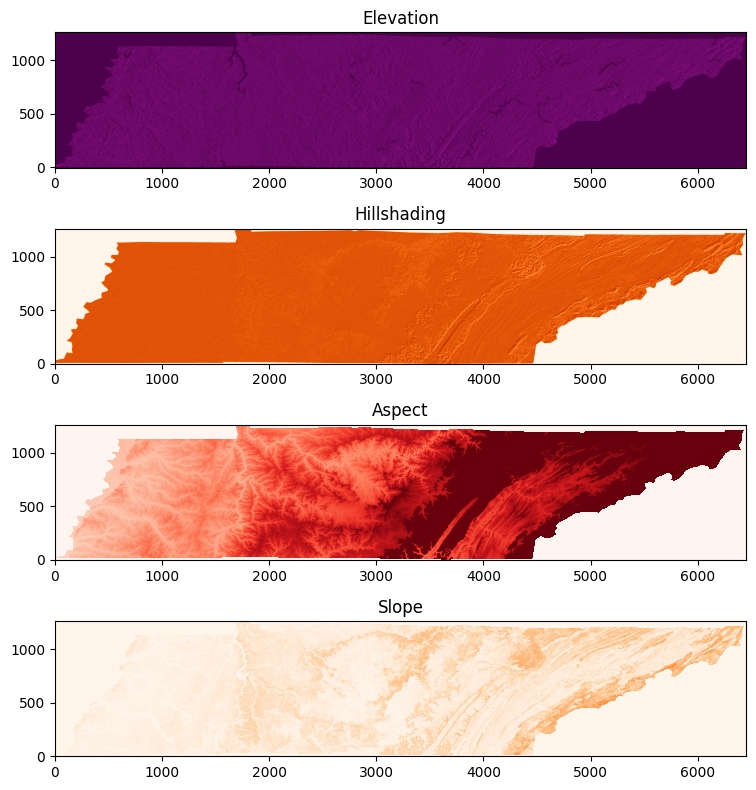

In [25]:
fig,axs=plt.subplots(4,1,figsize=(10,8))
axs[0].imshow(read_elevation,origin='lower',vmin=30,vmax=1999,cmap='BuPu_r')
axs[0].set_title('Elevation')
axs[1].imshow(read_hillshading,origin='lower',vmin=0,vmax=255,cmap='Oranges')
axs[1].set_title('Hillshading')

axs[2].imshow(read_aspect,vmin=0,origin='lower',vmax=360,cmap='Reds')
axs[2].set_title('Aspect')

axs[3].imshow(read_slope,vmin=0,origin='lower',vmax=65.9,cmap='Oranges')
axs[3].set_title('Slope')
plt.subplots_adjust(wspace=0.4,hspace=0.6)
plt.tight_layout()
plt.show()

## Step 4 - Create a dashboard with OpenVisus

### To run the dashboard, do the following: 

- First, make sure you can see the visualization above. 

- Run `setup_openvisuspy.sh` 

- Copy the *remote_dir* variable and replace it in dashboard.py file. 

- Run this command: `python3 -m bokeh serve --port 8989 dashboard.py`

Now, you can go to `localhost:8989` to see the dashboard!

*Suggestions:*
- In the dashboard, the `palette range` adjusts according to min/max of the data. Select `User` in `Range` and update accordingly, or select `dynamic` and switch back to  `User` to retain and update either of min/max values.
- More updates in the future will fix this issue.

In [14]:
%cd /app
!python -m bokeh serve --port 6000 dashboard.py

/app
2024-02-14 20:16:07,690 Starting Bokeh server version 3.3.4 (running on Tornado 6.4)
2024-02-14 20:16:07,693 User authentication hooks NOT provided (default user enabled)
2024-02-14 20:16:07,695 Bokeh app running at: http://localhost:6000/dashboard
2024-02-14 20:16:07,695 Starting Bokeh server with process id: 4158
^C

Interrupted, shutting down
